In [197]:
import requests
import numpy as np
import pandas as pd
import psycopg2
from bs4 import BeautifulSoup
from datetime import datetime, date, time
import string
import time
from dateutil import parser
import geopy.distance
import re
import pytz    
import tzlocal 
import matplotlib.pyplot as plt
import calendar
import matplotlib

pd.options.display.max_columns=100
%matplotlib inline


<input type="hidden" id="captchaStr" name="captchaStr" value="" />
<input type="hidden" id="type" name="type" value="igc" />

<input type="hidden" id="file" name="file" value="" />

### HOW TO SCRAPE A LOG FILE

In [503]:
data = {"flightID": 1860369, "file":"", "type":"igc", "captchaStr":""}

In [504]:
response = requests.post('http://www.paraglidingforum.com/leonardo/download_igc.php', data = data)
response.status_code

200

In [505]:
response.text

'AXGG1.66\r\nHFDTE010118\r\nHFFXA100\r\nHFPLTPILOT:\r\nHFGTYGLIDERTYPE:\r\nHFGIDGLIDERID:\r\nHFDTM100GPSDATUM:WGS84\r\nHFGPSGPS:SM-G892U\r\nHFRFWFIRMWAREVERSION:1.66\r\nHFRHWHARDWAREVERSION:1.66\r\nHFFTYFRTYPE:Geeksville,Gaggle\r\nI013638GSP\r\nB2124134730021N12200575WA0051700517030\r\nB2124284730046N12200650WA0048600486033\r\nB2124434730055N12200740WA0046300463037\r\nB2125084730079N12200824WA0041200412034\r\nB2125234730137N12200898WA0039000390030\r\nB2126034730164N12200999WA0028600286039\r\nB2126134730169N12201080WA0027500275033\r\nB2126284730175N12201204WA0025700257040\r\nB2126384730173N12201284WA0024500245039\r\nB2127344730102N12201247WA0009300093042\r\nB2127484730037N12201321WA0006900069043\r\nB2127584729983N12201297WA0005700057035\r\nB2128184730036N12201271WA0003500035002\r\nGGaggleFailedToSign\r\n'

### HOW TO SCRAPE THE FLIGHT NUMBERS

In [ ]:

flight_number = []

for page in range(1,110):

    headers = {
        'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36',
        'Referer': 'http://www.paraglidingforum.com/leonardo/page/filter',
        'page_num': str(page)}
    response = requests.get('http://www.paraglidingforum.com/leonardo/tracks/world/alltimes/brand:all,cat:0,class:all,xctype:all,club:all,pilot:0_0,takeoff:all&fltr=4242145_8929.&page_num={}'.format(page),headers = headers)
    soup = BeautifulSoup(response.text, "html.parser")
    flight_number.append([link["href"].split('/')[3] for link in soup.find_all("a", {"class":"flightLink"})])

In [ ]:
final_list = []
for page in flight_number:
    for flight in page:
        final_list.append(flight)

In [ ]:
#saving the flight numbers in a txt file

outfile = open('flights.txt', 'w')

for item in final_list:
    outfile.write(item)
    outfile.write(',')

### INTEGRATING WITH THE POSTGRES DB

In [121]:
conn = psycopg2.connect("dbname = soaring_predictor")

In [122]:
cur = conn.cursor()

In [14]:
query = """
INSERT INTO flight_log 
(flight,log) 
VALUES(%s,%s);
"""

test = """
SELECT log
FROM flights
where flight = 1360169;"""


In [ ]:
#testing the conmection 
cur.execute(test)
cur.fetchone()

In [ ]:
## This loop scrapes & saves into the SQL DB (1:1)

good_char = set(string.printable)

for i,flight in enumerate(final_list):
    
    data = {"flightID": int(flight), "file":"", "type":"igc", "captchaStr":""}
    response = requests.post('http://www.paraglidingforum.com/leonardo/download_igc.php', data = data)
    time.sleep(1)
    output = response.text


    data2 = [(int(flight),output)]


    records_list_template = ','.join(['%s'] * len(data2))
    insert_query = 'insert into flights (flight, log) values {}'.format(records_list_template)
    try:
        cur.execute(insert_query, data2)
    
    except:
        # This line does not do anything other than avoid an error (it was a try to take bad chars from the log)
        output = "".join([letter for letter in output if letter in good_char]) 
        
   
    if i % 100 == 0:
        conn.commit()
        print('Saved {} at {}'.format(i, datetime.now().strftime('%H:%M')))




In [382]:
cur.close()  # Close the cursor
conn.close() # Close the connection

### FUNCTIONS TO GET FEATURES FROM THE FLIGHT LOGS

In [361]:
'''List of features I want to get from the flight log:
            DATE
            PILOT NAME
            LAUNCH TIME
            LANDING TIME
            TOTAL FLIGHT TIME
            MAX ALTITUDE
            TOTAL ALTITUDE GAIN
            LAUNCH COORDINATES
            LANDING COORDINATES
            EUCLIDIAN DISTANCE BETWEEN LAUNCH AND LANDING
            LANDING = LAUNCH
            LEFT PERIMETER
'''

#returns the date of the flight (as datetime object)

def get_date(igc_file):
#     return parser.parse(igc_file.split('\n')[1][-6:],dayfirst=True).date()
    if igc_file.find('HFDTEDATE:') == -1:
        s = igc_file.find('HFDTE') + 5
    else:
        s = igc_file.find('HFDTEDATE:') + 10
    return parser.parse(igc_file[s:s+6],dayfirst=True).date()

# returns the month (as a string, in the format JAN, FEB...)

def get_month(dt_obj):
#     return calendar.month_name[dt_obj.month][0:3].upper()
    return dt_obj.month

def get_year(dt_obj):
#     return calendar.month_name[dt_obj.month][0:3].upper()
    return dt_obj.year



#returns pilot name

def pilot_name(igc_file):
    if igc_file.find('PILOT') == -1:
        return 'unknown'
    else:
        p = igc_file.find('PILOT')
        s = igc_file.find(':',p)
        e = igc_file.find('\n',s)
        return igc_file[s+1:e].strip('\r')
        
# returns launch time (as datetime object)

# This is to adjust the time from UTC tp PST

local_timezone = tzlocal.get_localzone() # get pytz tzinfo
utc_time = datetime.strptime("2011-01-21 02:37:21", "%Y-%m-%d %H:%M:%S")
local_time = utc_time.replace(tzinfo=pytz.utc).astimezone(local_timezone)

def launch_time(igc_file):
    m = re.search('B(.{6})47', igc_file, )
    if m:
        found = m.group(1)
        return datetime.strptime(found, '%H%M%S').replace(tzinfo=pytz.utc).astimezone(local_timezone).time()
    
# returns landing time (as datetime object)

def landing_time(igc_file):
    m = re.findall('B([0123456789]{13})N', igc_file )
    found = m[-1][:6]
    return datetime.strptime(found, '%H%M%S').replace(tzinfo=pytz.utc).astimezone(local_timezone).time()



# returns the total flying time (as datatime object, in seconds)

def flying_time(igc_file):
    x = launch_time(igc_file)
    y = landing_time(igc_file)
    diff = datetime.combine(date.today(), y) - datetime.combine(date.today(), x)
    return (diff.total_seconds() / 60 )  
   

#strip the altitude from a string - returns an int

def get_alt(alt_str):
    alt_str1 = int(alt_str[0:5])
    alt_str2 = int(alt_str[5:10])
    if alt_str2 != 0:
        return alt_str2
    elif alt_str !=0:
        return alt_str1

# for debug purposes ony - returns list of strings
def find_alt_entry(igc_file):
    a = re.search('WA([-0123456789]{3,16})', igc_file)
    if a:
        return a.group(1)
    

# returns the max altitude in the fligh (in meters)

def max_alt(igc_file):
    max_alt = 0
    m = re.findall('WA([-0123456789]{3,16})', igc_file)
    for i in m:
        if get_alt(i) > max_alt:
            max_alt = get_alt(i)
    return max_alt
    



# returns the total altitude gain in the flight (in meters):

def total_alt_gain(igc_file):
    total_alt_gain = 0
    m = re.findall('WA([-0123456789]{3,16})', igc_file)
    for s, t in zip(m, m[1:]):
        try:
            if len(t) <= 4:
                if int(t) > int(s):
                    total_alt_gain += (int(t) - int(s))
            elif int(t[5:10]) > int(s[5:10]):
                total_alt_gain += (int(t[5:10]) - int(s[5:10]))
        except:
            next
    return total_alt_gain

    
    

# returns launch coordinates

def launch_coord(igc_file):
    m = re.search('B(.{22}[01234567890NW])A', igc_file )
    if m:
        found = m.group(1)
        e = found.find('N')
        lat = found[e-7:e+1]
        lon = found[e+1:]
        lat = dec_lat(lat)
        lon = dec_lon(lon)
        return (lat,lon)

# returns landing coordinates

def landing_coord(igc_file):
    m = re.findall('B([01234567890NW]{23})A', igc_file )
    found = m[-1]
    e = found.find('N')
    lat = found[e-7:e+1]
    lon = found[e+1:]
    lat = dec_lat(lat)
    lon = dec_lon(lon)
    return (lat,lon)  


# returns the coordinates in decimals from string

def get_coord(item):
    lat = dec_lat(item[8:16])
    lon = dec_lon(item[16:25])
    return (lat,lon)

# returns the latitude in decimals from segregated string


def dec_lat(lat):
    D = float(lat[0:2])
    M = float(lat[2:7])
    S = float(lat[4:7])
    DD = D + M/60000 
    if lat[-1] == 'N':
        lat = DD
    elif lat[-1] == 'S':
        lat = -DD
    return lat

# returns the longitude in decimals from segregated string

def dec_lon(lon):
    D = float(lon[0:3])
    M = float(lon[3:8])
    S = float(lon[5:8])
    DD = D + M/60000 
    if lon[-1] == 'E':
        lon = DD
    elif lon[-1] == 'W':
        lon = -DD
    return lon


# returns the euclidian distance between landing and launch

def final_eucl_distance(igc_file):
    return geopy.distance.vincenty(launch_coord(igc_file), landing_coord(igc_file)).km


# returns the euclidian distance between two points (entry in coordinates, returns distance in km)

def eucl_distance(pt1,pt2):
    return geopy.distance.vincenty(pt1, pt2).km

# checks if landed at TIger LZ (0 if not, 1 if yes)

def landed_lz(igc_file):
    NW_corner = (47.502,-122.026)
    SE_corner = (47.498, -122.018)
    land_coord = landing_coord(igc_file)
    return int(NW_corner[0] >= land_coord[0] >= SE_corner[0] and NW_corner[1] <= land_coord[1] <= SE_corner[1])


#Checks if left the perimeter past north or east of the ridge tower or south or west of the nudist club

def left_perimeter(igc_file):    
    
    NE_edge = (47.5092,-121.986)
    SW_edge = (47.488,-122.04)
    left_per = 0
    m = re.findall('B([01234567890NW]{23})A', igc_file )
    for record in m:
        e = record.find('N')
        lat = record[e-7:e+1]
        lon = record[e+1:]
        lat = dec_lat(lat)
        lon = dec_lon(lon)
        if  (lat >= NE_edge[0] or lat <= SW_edge[0] or lon >= NE_edge[1]  or lon <= SW_edge[1]):
            left_per = 1
            break
    return left_per  


# returns day of the year

def doy(dt_obj):
    return int(dt_obj.strftime('%j'))




### CLEANING AND CREATING LABEL FEATUTES

In [1282]:
conn = psycopg2.connect("dbname = soaring_predictor")



In [144]:
Labels = pd.read_sql('SELECT * FROM flights;',conn)

In [145]:
'''There are some records with missing files...this list tags them. Next step is to drop them out'''

lst = []

for i in range(len(Labels)):
    try:
        get_date(Labels['log'][i])
    except:
        lst.append(i)
        
        
Labels.drop(lst, inplace=True)



In [191]:
'''Completed:
Labels['date'] = Labels['log'].apply(get_date)
Labels['pilot'] = Labels['log'].apply(pilot_name)
Labels['launch_time'] = Labels['log'].apply(launch_time)
Labels['landing_time']=Labels['log'].apply(landing_time)
Labels['flying_time'] = Labels['log'].apply(flying_time)
Labels['launch_coord']=Labels['log'].apply(launch_coord)
Labels['landing_coord']=Labels['log'].apply(landing_coord)
Labels['landed_lz']=Labels['log'].apply(landed_lz)
Labels['linear_dist']=Labels['log'].apply(final_eucl_distance)
Labels['max_alt']=Labels['log'].apply(max_alt)
Labels['total_alt_gain']=Labels['log'].apply(total_alt_gain)
Labels['left_perimiter']=Labels['log'].apply(left_perimeter)
Labels['month'] = Labels['date'].apply(get_month)
Labels['year'] = Labels['date'].apply(get_year)
--------------------------------------------------------
'''

# Labels['date'] = Labels['log'].apply(get_date)
# Labels['pilot'] = Labels['log'].apply(pilot_name)
# Labels['launch_time'] = Labels['log'].apply(launch_time)
# Labels['landing_time']=Labels['log'].apply(landing_time)
# Labels['flying_time'] = Labels['log'].apply(flying_time)
# Labels['launch_coord']=Labels['log'].apply(launch_coord)
# Labels['landing_coord']=Labels['log'].apply(landing_coord)
# Labels['landed_lz']=Labels['log'].apply(landed_lz)
# Labels['linear_dist']=Labels['log'].apply(final_eucl_distance)
# Labels['max_alt']=Labels['log'].apply(max_alt)
# Labels['total_alt_gain']=Labels['log'].apply(total_alt_gain)
# Labels['left_perimiter']=Labels['log'].apply(left_perimeter)
Labels['month'] = Labels['date'].apply(get_month)
Labels['year'] = Labels['date'].apply(get_year)
Labels['timestamp'] = pd.to_datetime(Labels['date'].apply(str) + ' '+ Labels['launch_time'].apply(str))
Labels['doy']= Labels['date'].apply(doy)

In [153]:
Labels = Labels[Labels['flying_time']>0] # deletes rows with negative flying times
Labels = Labels[Labels['year']>2012] # deletes rows older than 2013

#Removes records with crazy altitude - flight log is corrupted
l =list(Labels['flight'][Labels['max_alt']> 40000].index)
Labels.drop(l,inplace = True, axis=0)

In [428]:
Labels.head()


,flight,log,date,pilot,launch_time,landing_time,flying_time,launch_coord,landing_coord,landed_lz,linear_dist,max_alt,total_alt_gain,left_perimiter,month,year,alt_sampe,len_sampe,doy,timestamp
0,1860369,AXGG1.66\r\nHFDTE010118\r\nHFFXA100\r\nHFPLTPI...,2018-01-01,,13:31:13,13:35:18,4.083333,"(47.50035, -122.00958333333334)","(47.5006, -122.02118333333334)",1,0.874419,517,0,0,1,2018,0051700517030,13,1,2018-01-01 13:31:13
1,1803029,AXCSAAA\nHFDTE211217\nHFFXA050\nHFPLTPILOTINCH...,2017-12-21,AARON,16:35:41,16:43:57,8.266667,"(47.49933333333333, -122.00848333333333)","(47.49993333333333, -122.02186666666667)",1,1.010559,548,83,0,12,2017,000000054800000,15,355,2017-12-21 16:35:41
2,1755461,AXGD Flymaster NavSD SN01525 SW1.06j\r\nHFDT...,2017-11-18,Frank Henriquez,13:24:21,14:59:31,95.166667,"(47.49608333333333, -122.01065)","(47.50018333333333, -122.022)",1,0.969083,1057,2749,1,11,2017,0044200505,10,322,2017-11-18 13:24:21
3,1757934,AXCSAAA\nHFDTE181117\nHFFXA050\nHFPLTPILOTINCH...,2017-11-18,MEREDYTH MALOCSAY,13:26:17,14:21:06,54.816667,"(47.4967, -122.01033333333334)","(47.500366666666665, -122.02195)",1,0.965545,887,1123,1,11,2017,004360050701911,15,322,2017-11-18 13:26:17
4,1751790,AXCT XCTrack 0.6.0 on LGE Nexus 5X 8.0.0\r\nHP...,2017-11-17,Alex Leone,13:22:57,14:19:50,56.883333,"(47.49661666666667, -122.0102)","(47.4998, -122.02168333333333)",1,0.934814,1008,1446,1,11,2017,0044100499,10,321,2017-11-17 13:22:57


# EDA

[Text(0,0,'Jan'), Text(0,0,'Apr'), Text(0,0,'Jul'), Text(0,0,'Oct')]

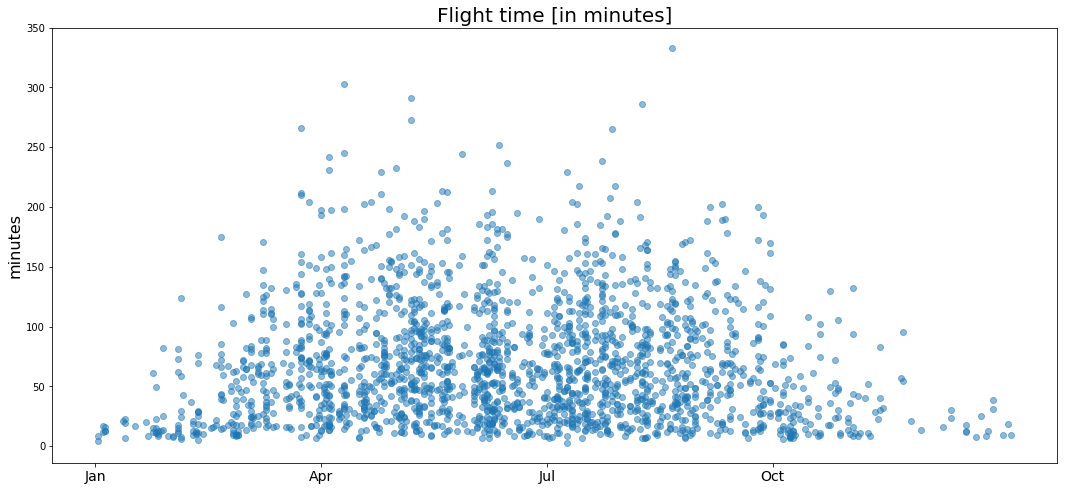

In [443]:


fig,ax = plt.subplots(figsize = (18,8))
ax.scatter(Labels['doy'], Labels['flying_time'], alpha = 0.5,)
ax.set_title('Flight time [in minutes]',fontsize=20)
ax.set_ylabel('minutes', fontsize=16)
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)

[Text(0,0,'Jan'), Text(0,0,'Apr'), Text(0,0,'Jul'), Text(0,0,'Oct')]

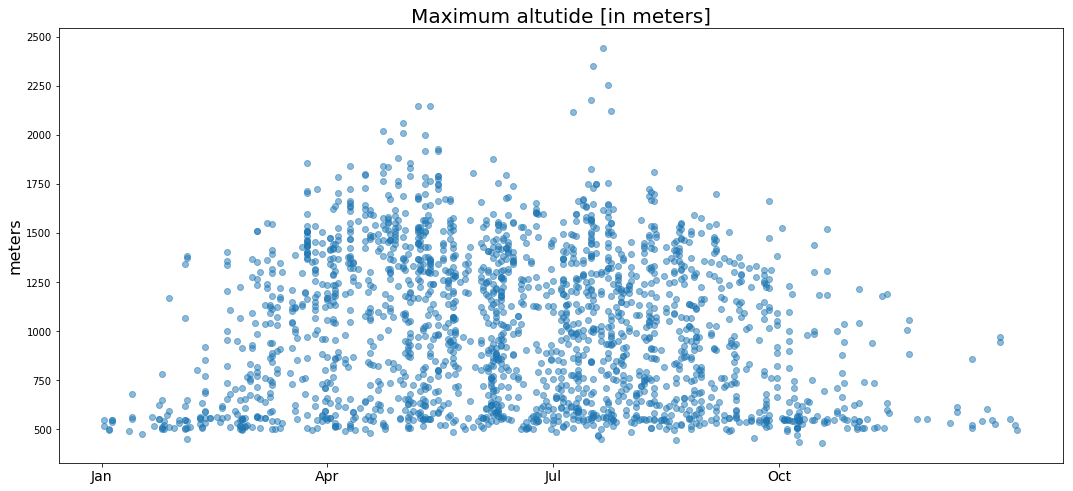

In [442]:
dates = matplotlib.dates.date2num(Labels['date'])
fig,ax = plt.subplots(figsize = (18,8))
ax.scatter(Labels['doy'], Labels['max_alt'], alpha = 0.5,)
ax.set_title('Maximum altutide [in meters]',fontsize=20)
ax.set_ylabel('meters', fontsize=16)
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)

[Text(0,0,'Jan'), Text(0,0,'Apr'), Text(0,0,'Jul'), Text(0,0,'Oct')]

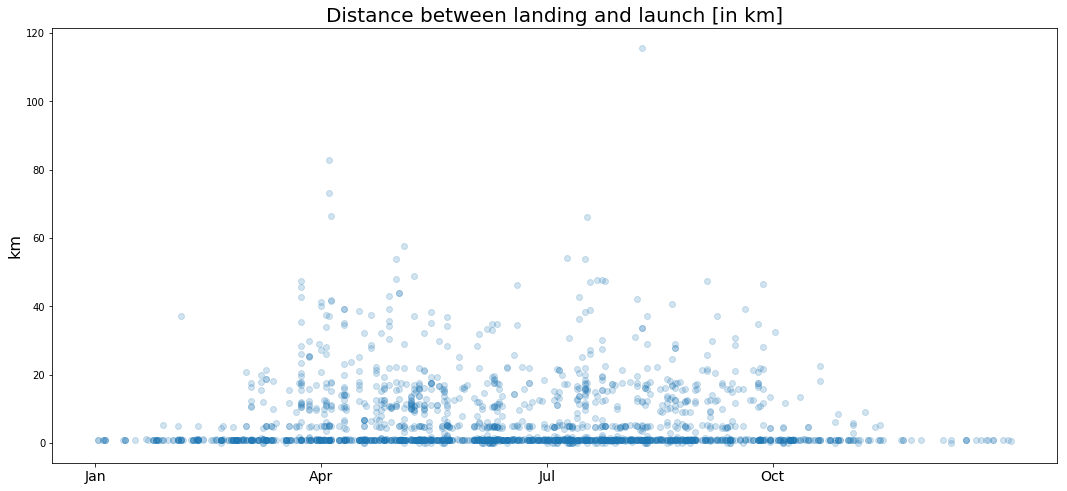

In [444]:
fig,ax = plt.subplots(figsize = (18,8))
ax.scatter(Labels['doy'], Labels['linear_dist'], alpha = 0.2,)
ax.set_title('Distance between landing and launch [in km]',fontsize=20)
ax.set_ylabel('km', fontsize=16)
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)

In [431]:
DF = Labels
DF.drop('log',axis=1, inplace=True)

In [384]:
#Sweet way to push DF to Postgres DB


import io

from sqlalchemy import create_engine

# fail, append or replace

def write_to_table(df, db_engine, table_name, if_exists='fail'):
    string_data_io = io.StringIO()
    df.to_csv(string_data_io, sep='|', index=False)
    pd_sql_engine = pd.io.sql.pandasSQL_builder(db_engine)
    table = pd.io.sql.SQLTable(table_name, pd_sql_engine, frame=df,
                               index=False, if_exists=if_exists)
    table.create()
    string_data_io.seek(0)
    string_data_io.readline()  # remove header
    with db_engine.connect() as connection:
        with connection.connection.cursor() as cursor:
            copy_cmd = "COPY %s FROM STDIN HEADER DELIMITER '|' CSV" % table_name
            cursor.copy_expert(copy_cmd, string_data_io)
        connection.connection.commit()

In [385]:
address = 'postgresql://@localhost:5432/soaring_predictor'
engine = create_engine(address)

In [433]:
write_to_table(DF, engine, 'flight_metrics')